In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from my_awesome_eda import run_eda
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


/scratch/ipykernel_3782905/1099418069.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%load_ext autoreload
%autoreload 2

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [4]:
run_eda(data)

Greetings, stranger! Please get acquainted with data

Number of observations: 17996
Number of parameters: 17

Categorical variables: key, mode, time_signature, Class
Numerical variables: Popularity, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_in min/ms
String variables: Artist Name, Track Name

Categorical variables statistics:


,counts,frequencies
key,,
7.0,2097,0.131210
2.0,1994,0.124765
9.0,1961,0.122701
1.0,1680,0.105118
4.0,1549,0.096922
11.0,1476,0.092354
5.0,1397,0.087411
6.0,1190,0.074459
8.0,1119,0.070016


,counts,frequencies
mode,,
1,11459,0.636753
0,6537,0.363247


,counts,frequencies
time_signature,,
4,16451,0.914148
3,1228,0.068237
5,203,0.011280
1,114,0.006335


,counts,frequencies
Class,,
10,4949,0.275006
6,2587,0.143754
9,2524,0.140253
8,1854,0.103023
5,1447,0.080407
1,1373,0.076295
2,1272,0.070682
0,625,0.034730
7,576,0.032007




Numerical variables statistics:


,count,mean,std,min,25%,50%,75%,max,median,IQR
Popularity,17568.0,44.512124,17.426928,1.000000,33.000000,44.00000,56.00000,100.000,44.00000,23.000000
danceability,17996.0,0.543433,0.166268,0.059600,0.432000,0.54500,0.65900,0.989,0.54500,0.227000
energy,17996.0,0.662777,0.235373,0.000020,0.509000,0.70000,0.86000,1.000,0.70000,0.351000
loudness,17996.0,-7.910660,4.049151,-39.952000,-9.538000,-7.01600,-5.18900,1.355,-7.01600,4.349000
speechiness,17996.0,0.079707,0.083576,0.022500,0.034800,0.04740,0.08300,0.955,0.04740,0.048200
acousticness,17996.0,0.247082,0.310632,0.000000,0.004300,0.08140,0.43400,0.996,0.08140,0.429700
instrumentalness,13619.0,0.177562,0.304048,0.000001,0.000089,0.00391,0.20000,0.996,0.00391,0.199911
liveness,17996.0,0.196170,0.159212,0.011900,0.097500,0.12900,0.25800,1.000,0.12900,0.160500
valence,17996.0,0.486208,0.240195,0.018300,0.297000,0.48100,0.67200,0.986,0.48100,0.375000
tempo,17996.0,122.623294,29.571527,30.557000,99.620750,120.06550,141.96925,217.416,120.06550,42.348500


,Number of outliers
Popularity,41
danceability,31
loudness,818
speechiness,2034
instrumentalness,2408
liveness,956
tempo,36
duration_in min/ms,3245


Number of missing values: 6819
Number of duplicated rows: 0


In [5]:
num_vars = ['Popularity', 'danceability', 'energy', 
           'loudness', 'speechiness', 'acousticness', 
           'instrumentalness', 'liveness', 'valence', 
           'tempo', 'duration_in min/ms']

# Давайте также отрисуем распределения числовых переменных:

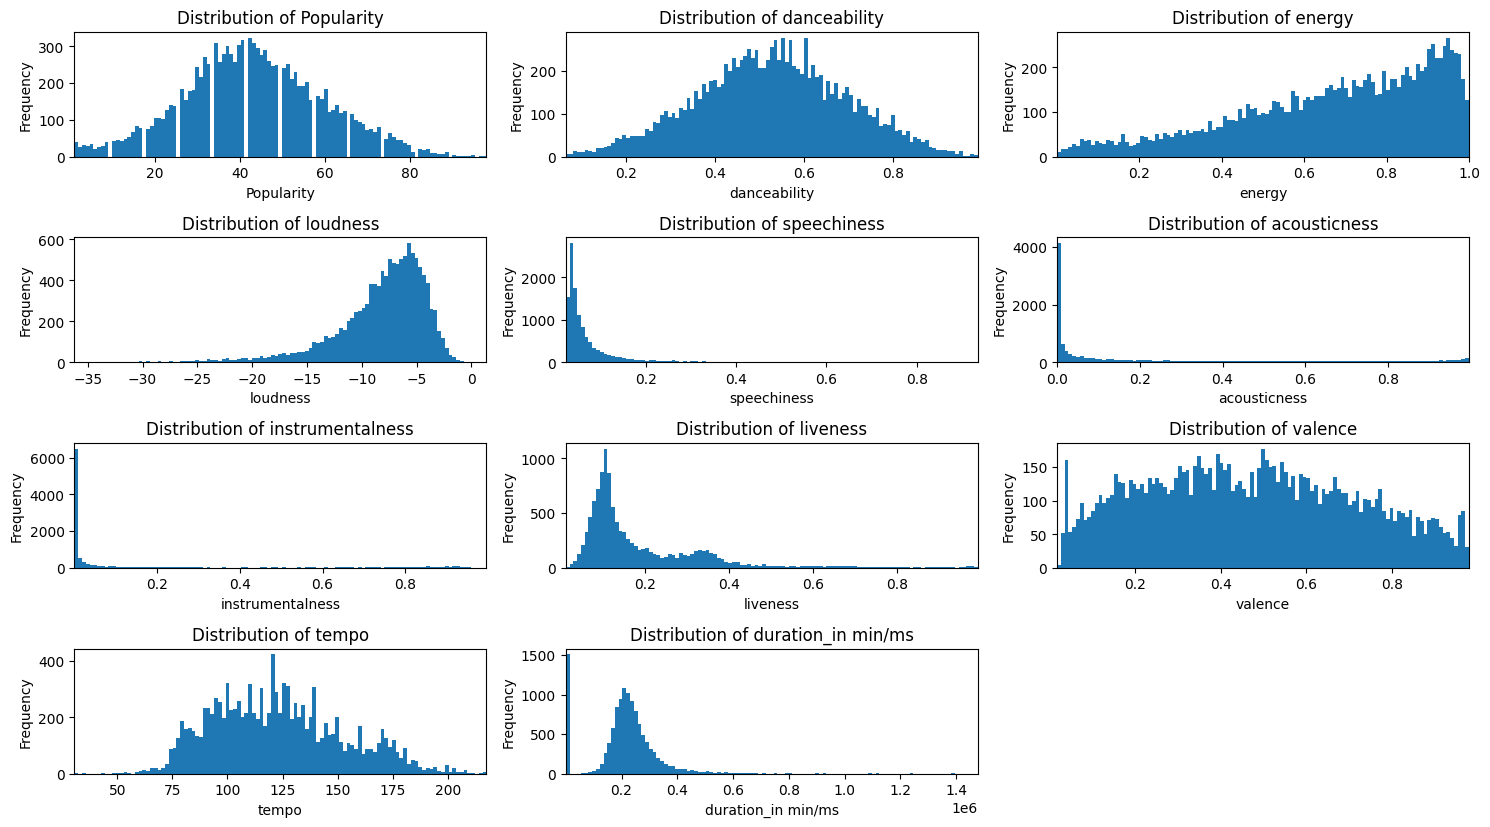

In [6]:
na_dropped_data = data.dropna()
n_bins = int(round(na_dropped_data.shape[0] ** 0.5))

plt.figure(figsize=(15, 10))

for i, column in enumerate(num_vars):
    plt.subplot(5, 3, i + 1)
    plt.hist(na_dropped_data[column], bins=n_bins)
    plt.title(f"Distribution of {column}")
    plt.xlim(min(na_dropped_data[column]), max(na_dropped_data[column]))
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Исходя из EDA наблюдается дисбаланс классов. Потому в дальнейшем будем применять f1_score_macro метрику
 
Будем дальше рассмотривать категориальными следующие переменные: mode, time_signature, key. 

Для них используем OneHotEncoder, для численных переменных исопльзуем StadardScaler (можно был бы обойтись, но почему нет). Строковые переменные отбросим


In [7]:
num_vars = ['Popularity', 'danceability', 'energy', 'key', 
           'loudness', 'speechiness', 'acousticness', 
           'instrumentalness', 'liveness', 'valence', 
           'tempo', 'duration_in min/ms']
cat_vars = ['mode', 'time_signature', 'key']

In [8]:
y = data['Class']
data = data.drop(columns=['Artist Name', 'Track Name', 'Class'])

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [20]:
X = data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15, 
                                                    random_state=111,
                                                    stratify = y)

In [10]:
param_grid = {
    'max_depth': list(range(50, 500, 50)),
    'min_samples_leaf': list(range(5, 40, 5)),
}

In [11]:
dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='f1_macro')

In [12]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [50, 100, 150, 200, 250, 300, 350, 400,
                                       450],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35]},
             scoring='f1_macro')

In [13]:
max_depth = grid_search.best_params_['max_depth']
min_sample_leaf = grid_search.best_params_['min_samples_leaf']

In [21]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_vars),
    ("ohe", OneHotEncoder(drop="first"), cat_vars)
])

In [22]:
decision_tree_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("decision_tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_sample_leaf))
])
decision_tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Popularity', 'danceability',
                                                   'energy', 'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo',
                                                   'duration_in min/ms']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['mode', 'time_signature',
                                                   'key'])])),
                ('decision_tree',
                 DecisionTreeClassifier(max_depth=300, min_samples_leaf=15))])

In [23]:
y_pred = decision_tree_pipeline.predict(X_test)

In [24]:
f1_score_macro = f1_score(y_test, y_pred, average='macro')
print(f'The f1_score is: {f1_score_macro}')

The f1_score is: 0.49686447926097


f1_score был выбран, поскольку мы имеем дело с многоклассовой классификацией и с дисбалансом между классами.

Полученный скор конечно совсем уж небольшой, однако мне кажется дело в том, что одного бинарного дерева недостаточно, чтобы с большей точностью определять класс песен...  

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

Сорри, подустал я...

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Поймай меня если сможешь. Люблю фильмы с Томом Хэнксом, а в дуэте с Дикаприо - просто пушка

2. Клаус - слишком добрый мультик. За рисовку отдельный респект 

3. Каникулы строгого режима - недавно вот пересмтаривал :) Наши тоже могут, когда захотят...